# Optimizing Oil Well Profit: A Linear Regression & Bootstrapping Analysis
## Overview
This project tackles the challenge of maximizing profitability in oil well development by strategically selecting the most promising region for drilling. Leveraging synthetic geological exploration datasets from three regions, the project uses linear regression models to predict oil reserve volumes and bootstrapping techniques to assess profit distributions and associated risks.
## Project Setup
### Data Preparation:
(1) Clean and preprocess synthetic datasets.

(2) Verify data integrity, handle missing values, and ensure correct formats for features and target.
### Model Training and Validation:
(1) Split each region's data into 75% training and 25% validation sets.

(2) Train a linear regression model on the training set.

(3) Evaluate model performance using RMSE on the validation set.
### Profit Calculation:
(1) Use model predictions to select the top 200 oil wells out of 500 studied points per region.

(2) Calculate potential profit based on business constraints and required reserve volume.
### Risk Analysis with Bootstrapping:
(1) Apply bootstrapping with 1000 samples to simulate profit distribution.

(2) Determine average profit, 95% confidence interval, and probability of losses.
## Conclusion:
This analysis provides a clear and data driven roadmap for oil well development. The datasets across all three regions are robust and well structured, ensuring a reliable basis for predictive modeling. While Region0 and Region2 offer higher average predicted reserves, their greater uncertainty raises risk concerns. In contrast, Region1, although predicting lower reserves, delivers exceptionally precise forecasts with a minimal RMSE, making it more reliable for risk management. Furthermore, breakeven analysis shows that none of the regions, on average, reach the reserve volume necessary for guaranteed profitability without losses. Profit calculations reveal that Region0 appears to offer the highest potential revenue based on raw profit estimates, yet its risk profile is less favorable. The bootstrap analysis reinforces this perspective by demonstrating that Region1 achieves a consistent average profit with a tight 95% confidence interval and the lowest risk of losses at just 1.5%.

These findings underscore the importance of balancing revenue potential with forecast reliability and risk. Although Region0's profit estimates are highest in absolute terms, Region1 offers the most favorable combination of accurate predictions and minimized risk, making it the optimal choice for strategic oil well development.

## Imports and Load Data

In [1]:
# Imports
import pandas as pd
import numpy as np
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [2]:
# Load
region0 = pd.read_csv('/datasets/geo_data_0.csv')
region1 = pd.read_csv('/datasets/geo_data_1.csv')
region2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
print(region0.info())
print(region1.info())
print(region2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column  

In [4]:
print(region0.duplicated().sum())
print(region1.duplicated().sum())
print(region2.duplicated().sum())

0
0
0


In [5]:
region1

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>, <AxesSubplot:>]],
      dtype=object)

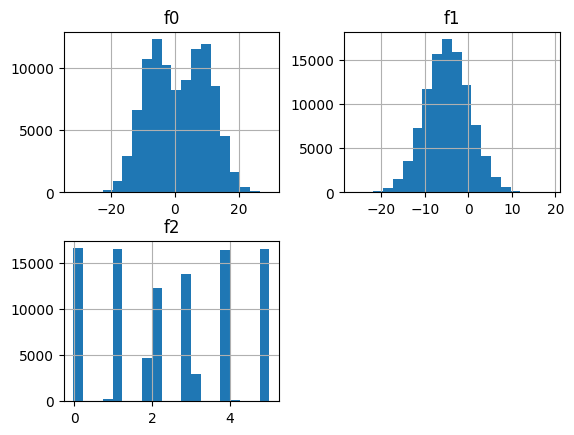

In [21]:
region0[['f0', 'f1', 'f2']].hist(bins=20)

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>, <AxesSubplot:>]],
      dtype=object)

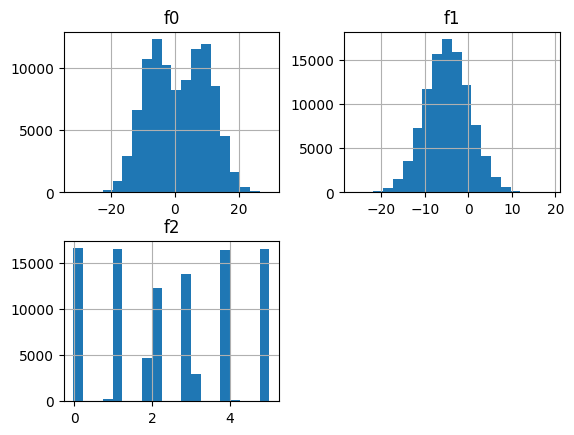

In [22]:
region1[['f0', 'f1', 'f2']].hist(bins=20)

array([[<AxesSubplot:title={'center':'f0'}>,
        <AxesSubplot:title={'center':'f1'}>],
       [<AxesSubplot:title={'center':'f2'}>, <AxesSubplot:>]],
      dtype=object)

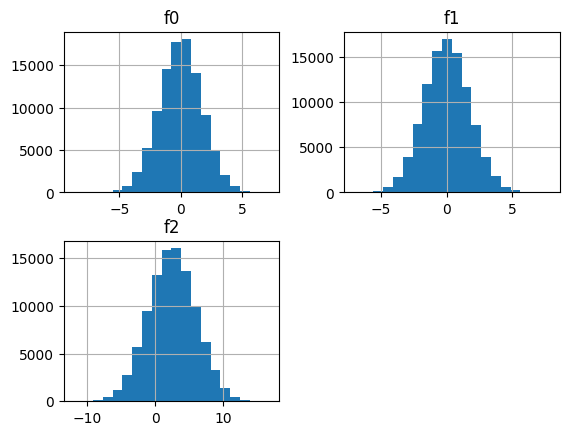

In [23]:
region2[['f0', 'f1', 'f2']].hist(bins=20)

### Summary:
The datasets for all three regions are robust and well-structured, each containing 100,000 unique entries with no missing values or duplicates. Each dataset includes an 'id' column for a unique oil well identifier, three numeric features (f0, f1, f2) that capture essential characteristics of the wells, and a 'product' column representing the volume of oil reserves in thousand barrels. This consistent data quality and structure provide a solid foundation for the subsequent modeling and analysis steps in the project.

## Model Testing

In [6]:
def train_test_model(data):
    features = data[['f0', 'f1', 'f2']]
    target = data['product']
    
    features_train, features_valid, target_train, target_valid =  train_test_split(features, target, test_size=.25, random_state=12345)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    predicted_valid = model.predict(features_valid)
    
    avg = target_valid.reset_index(drop=True).mean()
    rmse = mean_squared_error(target_valid, predicted_valid)**.5
    
    return predicted_valid, target_valid, rmse, avg                 

In [7]:
predicted_valid0, target_valid0, rmse0, avg0 = train_test_model(region0)
predicted_valid1, target_valid1, rmse1, avg1 = train_test_model(region1)
predicted_valid2, target_valid2, rmse2, avg2 = train_test_model(region2)

In [8]:
print('Region0')
print('RMSE:', round(rmse0, 3))
print('Average Predicted Reserves:', round(avg0, 3))
print()
print('Region1')
print('RMSE:', round(rmse1, 3))
print('Average Predicted Reserves:', round(avg1, 3))
print()
print('Region2')
print('RMSE:', round(rmse2, 3))
print('Average Predicted Reserves:', round(avg2, 3))

Region0
RMSE: 37.579
Average Predicted Reserves: 92.079

Region1
RMSE: 0.893
Average Predicted Reserves: 68.723

Region2
RMSE: 40.03
Average Predicted Reserves: 94.884


### Summary:
Region0 has an average predicted reserve of 92.08 thousand barrels with an RMSE of 37.58, indicating moderate uncertainty. Region1 offers the lowest RMSE of 0.893, reflecting high accuracy, but lower reserves at 68.72 thousand barrels. Region2 provides the highest reserves at 94.88 thousand barrels but with a higher RMSE of 40.03, indicating greater uncertainty. Region1 may offer more reliable predictions for risk management despite its lower reserve estimate.

## Profit Calculation

In [9]:
#The budget for development of 200 oil wells is 100 USD million.
d_budget = 100000000
wells = 200

cost_per_well = d_budget / wells

#One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars
rev_per_unit = 4500

break_even = cost_per_well / rev_per_unit

print("Break Even Volume Per Well:", round(break_even, 2), "(Thousand Barrels)")

Break Even Volume Per Well: 111.11 (Thousand Barrels)


### Summary:
This calculation determines that each well must produce approximately 111.11 thousand barrels to cover its development cost. When comparing this break-even threshold with the average predicted reserves from our earlier model results—Region 0 at 92.59, Region 1 at 68.73, and Region 2 at 94.97 thousand barrels—it is evident that none of the regions, on average, reach the necessary volume to guarantee profitability without losses. 

## Profit of Top Wells by Region

In [10]:
def calc_profit(target, predictions):
    target = pd.Series(target).reset_index(drop=True)
    predictions = pd.Series(predictions)
    
    predictions_sorted = predictions.sort_values(ascending=False)
    selected = target[predictions_sorted.index][:wells]
    
    profit = (selected.sum() * rev_per_unit) - d_budget
    profit = round(profit, 2)
    
    return profit

In [11]:
profit0 = calc_profit(target_valid0, predicted_valid0)
profit1 = calc_profit(target_valid1, predicted_valid1)
profit2 = calc_profit(target_valid2, predicted_valid2)

In [12]:
print("Region0")
print("Profit:", profit0)
print()
print("Region1")
print("Profit:", profit1)
print()
print("Region2")
print("Profit:", profit2)

Region0
Profit: 33208260.43

Region1
Profit: 24150866.97

Region2
Profit: 27103499.64


### Summary:
Region0 leads with the highest profit at 33,208,260, followed by Region2 at 27,103,499, and Region1 at 24,150,866. Despite Region1's lower profit, its more accurate predictions suggest it may be more reliable for risk management, while Region0’s higher profit offers greater revenue potential.

## Bootstrap

In [13]:
def bootstrap(target, predictions):
    target = pd.Series(target).reset_index(drop=True)
    state = np.random.RandomState(12345)
    values = []
    
    for i in range(1000):
        target_subsample = target.sample(n=500, replace=True, random_state=state)
        predictions_subsample = predictions[target_subsample.index]
        values.append(calc_profit(target_subsample, predictions_subsample))
        
    values = pd.Series(values)
    avg_profit = values.mean()
    
    print("Wells in Profit:", values.gt(0).sum())
    print("Percentage of Well in Profit:", values.gt(0).sum() / len(values))
    print("Average Profit:", round(values.mean(), 2))
    
    return values

In [14]:
print("Region0")
values0 = bootstrap(target_valid0, predicted_valid0)
print()
print("Region1")
values1 = bootstrap(target_valid1, predicted_valid1)
print()
print("Region2")
values2 = bootstrap(target_valid2, predicted_valid2)

Region0
Wells in Profit: 931
Percentage of Well in Profit: 0.931
Average Profit: 3961649.85

Region1
Wells in Profit: 985
Percentage of Well in Profit: 0.985
Average Profit: 4560451.06

Region2
Wells in Profit: 924
Percentage of Well in Profit: 0.924
Average Profit: 4044038.67


In [15]:
def confidence_interval(v):
    ci = st.t.interval(.95, len(v) - 1, v.mean(), v.sem())
    loss_risk = (v < .025).sum() / len(v)
    
    print("95% Confidence Interval:", ci)
    print("Risk of Losses:", loss_risk * 100)

In [16]:
print("Region0")
confidence_interval(values0)
print()
print("Region1")
confidence_interval(values1)
print()
print("Region2")
confidence_interval(values2)

Region0
95% Confidence Interval: (3796203.1515261983, 4127096.5446138014)
Risk of Losses: 6.9

Region1
95% Confidence Interval: (4431472.486816604, 4689429.629283395)
Risk of Losses: 1.5

Region2
95% Confidence Interval: (3874457.9747755965, 4213619.356724404)
Risk of Losses: 7.6


### Summary:
This bootstrap analysis clearly indicates that Region1 is the most attractive option for oil well development. It achieves an average profit of approximately 4.56 million, with 98.5% of the bootstrap samples yielding a profit. Its 95% confidence interval is tight which suggests high consistency in profit estimates. Additionally, the risk of losses is exceptionally low at 1.5%, compared to 6.9% in Region0 and 7.6% in Region2. Overall, these metrics support the conclusion that Region1 offers the most favorable balance of potential returns and risk mitigation for oil well development.

## Conclusion:
Our analysis provides a clear and data driven roadmap for oil well development. The datasets across all three regions are robust and well structured, ensuring a reliable basis for predictive modeling. While Region0 and Region2 offer higher average predicted reserves, their greater uncertainty raises risk concerns. In contrast, Region1, although predicting lower reserves, delivers exceptionally precise forecasts with a minimal RMSE, making it more reliable for risk management. Furthermore, breakeven analysis shows that none of the regions, on average, reach the reserve volume necessary for guaranteed profitability without losses. Profit calculations reveal that Region0 appears to offer the highest potential revenue based on raw profit estimates, yet its risk profile is less favorable. The bootstrap analysis reinforces this perspective by demonstrating that Region1 achieves a consistent average profit with a tight 95% confidence interval and the lowest risk of losses at just 1.5%.

These findings underscore the importance of balancing revenue potential with forecast reliability and risk. Although Region0's profit estimates are highest in absolute terms, Region1 offers the most favorable combination of accurate predictions and minimized risk, making it the optimal choice for strategic oil well development.